# Machine Learning Model Analysis

The purpose of this analysis is to provide the best machine learning model for Black Rock to predict the likihood if tomorrow's closing price being higher or lower than today's closing price

I am going to use Black rock's maximum of data available to train and test the model

In [1]:
# Importing Libraries
# Data Handling
import pandas as pd
import numpy as np
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)# Financial Data Analysis
import yfinance as yf
import ta
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Models
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier # Hiding warnings
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Loading BlackRock stocks until Aug 29th, 2023
blk = yf.download('BLK', end = '2023-08-29')
blk

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
1999-10-01   14.000000   14.250000   14.000000   14.125000    8.955749   
1999-10-04   14.125000   14.125000   14.000000   14.000000    8.876496   
1999-10-05   14.000000   14.125000   14.000000   14.125000    8.955749   
1999-10-06   14.125000   14.875000   14.125000   14.875000    9.431278   
1999-10-07   14.875000   14.875000   14.062500   14.125000    8.955749   
...                ...         ...         ...         ...         ...   
2023-08-22  671.590027  674.760010  664.609985  665.840027  665.840027   
2023-08-23  668.400024  680.330017  667.119995  678.770020  678.770020   
2023-08-24  678.780029  688.580017  672.969971  673.159973  673.159973   
2023-08-25  676.000000  682.200012  671.260010  675.960022  675.960022   
2023-08-28  681.309998  683.539978  674.630005  679.000000  679.000000   

             Volume  
Date                 
1999-10-01  3162400  
1999-10-04   533400  
1999-10-05   270600  
1999-10-06   205400  
1999-10-07   214200  
...             ...  
2023-08-22   332500  
2023-08-23   386800  
2023-08-24   317900  
2023-08-25   275200  
2023-08-28   430900  

[6015 rows x 6 columns]

In [3]:
open_data = blk['Open']
high_data = blk['High']
low_data = blk['Low']
close_data = blk['Close']
dates = blk.index  

trace = go.Candlestick(x=dates,
                open=open_data,
                high=high_data,
                low=low_data,
                close=close_data)

layout = go.Layout(
    title='BlackRock Stock Price (Candlestick)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price (in USD)'),
    plot_bgcolor='rgba(230, 230, 230, 0.8)',  # Setting a background color for better clarity
)

fig = go.Figure(data=[trace], layout=layout)


fig.show()


In [4]:
# Data Splitting
train = blk[blk.index.year <= 2010] 
test = blk[blk.index.year >= 2011]

In [5]:
# Adding Close_Shift Variable
train['Close_Shift'] = train['Adj Close'].shift(1) 
test['Close_Shift'] = test['Adj Close'].shift(1)

In [6]:
# Adding Daily Returns variable
train['Return'] = (train['Adj Close']/train['Close_Shift'] - 1) * 100 
test['Return'] = (test['Adj Close']/test['Close_Shift'] - 1) * 100

In [7]:
# Creating target variable on both datasets
train['target'] = np.where(train['Return'].shift(-1) > 0, 1, 0) 
test['target'] = np.where(test['Return'].shift(-1) > 0, 1, 0)

In [8]:
X_train = train.drop('target', axis = 1)  # Selecting Predictor Variables
y_train = train['target']  # Selecting Target Variable

X_test = test.drop('target', axis = 1)  # Selecting Predictor Variables
y_test = test['target']  # Selecting Target Variable

In [9]:
# Defining feature engineering function
def feature_engineering(df):
# Adding Simple Moving Averages
    df['sma5'] = ta.trend.sma_indicator(df['Adj Close'],window = 5) 
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'],window = 10) 
    df['sma15'] = ta.trend.sma_indicator(df['Adj Close'],window = 15) 
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'],window = 20) 
    df['sma30'] = ta.trend.sma_indicator(df['Adj Close'],window = 30) 
    df['sma50'] = ta.trend.sma_indicator(df['Adj Close'],window = 50) 
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'],window = 80) 
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'],window = 100) 
    df['sma200'] = ta.trend.sma_indicator(df['Adj Close'],window = 200)
    # Adding Price to Simple Moving Averages ratios
    df['sma5_ratio'] = df['Adj Close'] / df['sma5'] 
    df['sma10_ratio'] = df['Adj Close'] / df['sma10'] 
    df['sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['sma30_ratio'] = df['Adj Close'] / df['sma30'] 
    df['sma50_ratio'] = df['Adj Close'] / df['sma50'] 
    df['sma80_ratio'] = df['Adj Close'] / df['sma80'] 
    df['sma100_ratio'] = df['Adj Close'] / df['sma100'] 
    df['sma200_ratio'] = df['Adj Close'] / df['sma200']

    # Adding RSI, CCI, Bollinger Bands, and OBV
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Adj Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    # Adding features derived from the indicators above
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int) 
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int) 
    df['above_bb_high'] = (df['Adj Close'] >= df['bb_high']).astype(int) 
    df['below_bb_low'] = (df['Adj Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close' ].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close' ].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int) 
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int) 
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int) 
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int) 
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int) 
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int) 
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)
    # Removing NaN values from the dataframe
    df.dropna(inplace = True) 
    return df

In [10]:
# Applying function to the X_train and X_test sets
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [11]:
# Removing from y_train and y_test the NaN values that were dropped from X_train and X_t est by the index
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [12]:
# Creating a list of different classification models
classifiers = [
    LogisticRegression(random_state = 42), 
    XGBClassifier(random_state = 42), 
    LGBMClassifier(random_state = 42), 
    CatBoostClassifier(random_state = 42, verbose = False), 
    AdaBoostClassifier(random_state = 42), 
    RandomForestClassifier(random_state = 42)
]
# Iterating over classifiers in the list above, training, and evaluating them
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred) 
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.501
XGBClassifier: AUC Score=0.508
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1331, number of negative: 1301
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 2632, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505699 -> initscore=0.022797
[LightGBM] [Info] Start training from score 0.022797
LGBMClassifier: AUC Score=0.499
CatBoostClassifier: AUC Score=0.504
AdaBoostClassifier: AUC Score=0.515
RandomForestClassifier: AUC Score=0.503


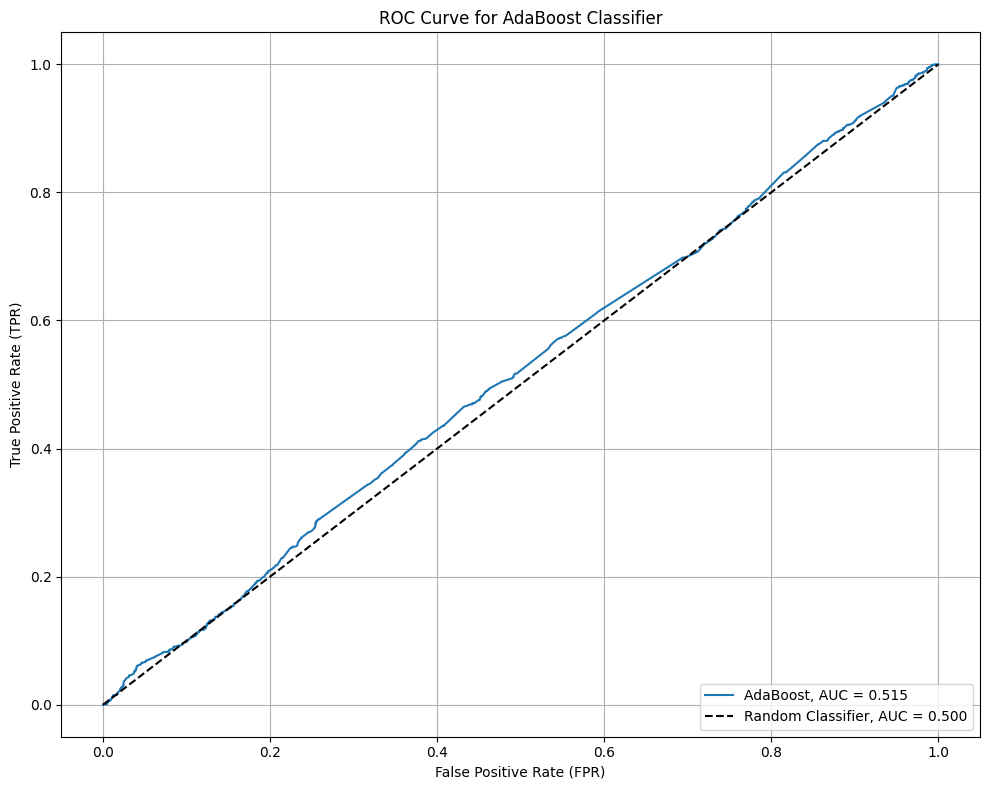

In [13]:
# Train AdaBoostClassifier and get the probabilities for the positive class
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label=f"AdaBoost, AUC = {auc(fpr, tpr):.3f}")
plt.plot([0,1], [0,1], 'k--', label="Random Classifier, AUC = 0.500")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for AdaBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

AUC = 0.5: This suggests no discrimination, which means the model's prediction is no better than random guessing. It's akin to flipping a coin. In your results, LogisticRegression and RandomForestClassifier have AUCs very close to 0.5, suggesting they're not providing any meaningful discrimination for the dataset you've provided.

0.5 < AUC < 1: This indicates some discrimination power, with higher values being better. An AUC of 1 indicates a perfect classifier, where it can perfectly separate the two classes. In practice, an AUC score above 0.8 or 0.9 is considered excellent. In your results, none of the models achieved a high AUC. The highest AUC you have is from AdaBoostClassifier with an AUC of 0.515, which suggests very minimal predictive power beyond random guessing.

AUC < 0.5: Technically, this indicates a model that's doing worse than random guessing. However, you can invert its predictions to achieve an AUC greater than 0.5. In most real-world applications, an AUC less than 0.5 indicates that something may be wrong with the data preprocessing or the way the model is trained.

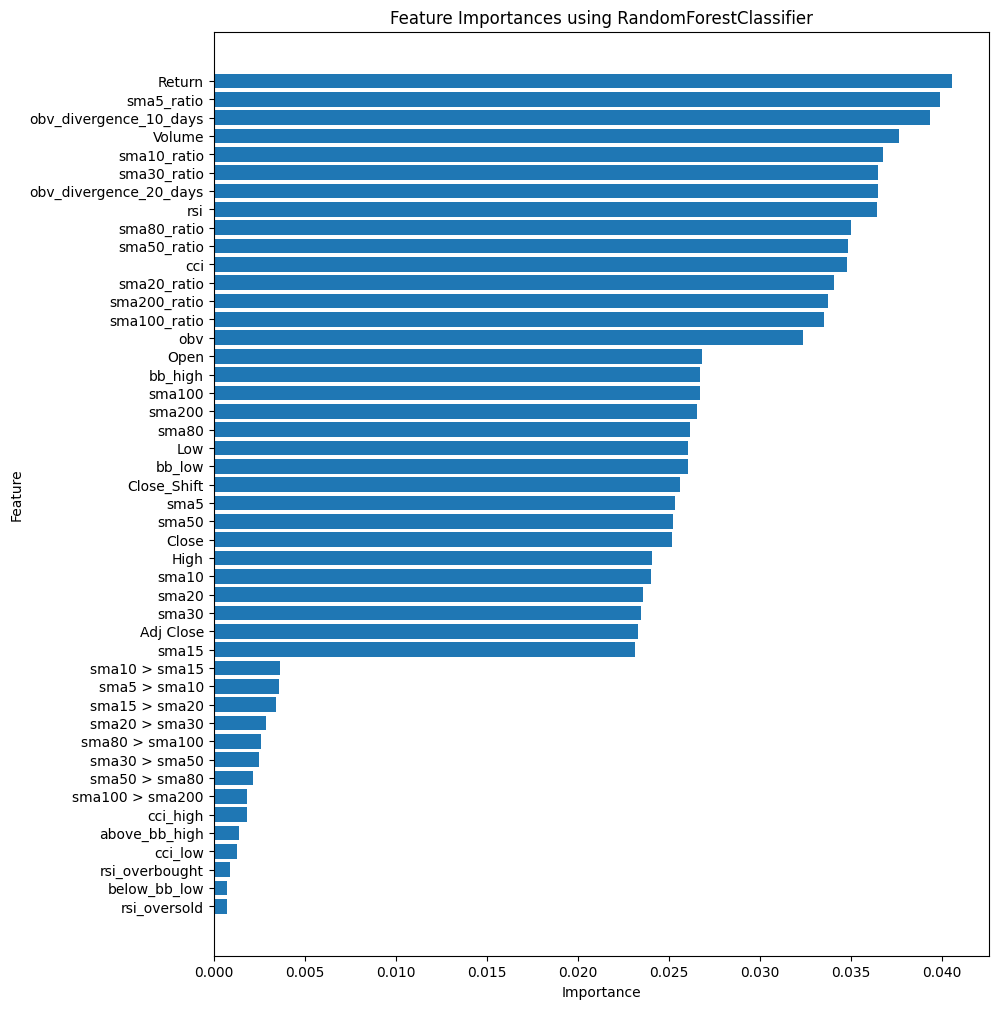

In [14]:
# Train a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Get the indices of the sorted feature importances
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances using RandomForestClassifier')
plt.show()


In [15]:
y_pred

array([0.48, 0.52, 0.48, ..., 0.3 , 0.32, 0.24])

In [16]:
quantile_intervals = np.arange(0, 1.125, 0.125) # Creating intervals for the quantiles 
quantile_values = np.quantile(y_pred_proba, quantile_intervals) # Dividing y_pred in 8 different quantiles

classes = pd.cut(y_pred_proba, quantile_values) # Grouping probabilities according to the quantiles
X_test['y_true'] = y_test # Creating a new column in the X_test set containing the true label values
table = pd.crosstab(classes, X_test['y_true']) # Creating a table counting true labels according to each probability range

print(table)

y_true              0    1
row_0                     
(0.187, 0.1911]   188  187
(0.1911, 0.1915]  170  211
(0.1915, 0.1918]  220  207
(0.1918, 0.1919]  146  163
(0.1919, 0.1925]  201  208
(0.1925, 0.1929]  157  181
(0.1929, 0.1972]  160  212
(0.1972, 0.6882]  177  196


In [17]:
sign = np.zeros_like(y_pred_proba) # Creating an array with 0s in the same length as y_pred
# Short selling signal
sign[((y_pred_proba >= 0.3477) & (y_pred_proba < 0.5087)) | ((y_pred_proba > 0.5189) & (y_pred_proba < 0.5195) )] = -1
# Buying signal
sign[((y_pred_proba >= 0.5087) & (y_pred_proba <= 0.5189)) |
((y_pred_proba >= 0.5195) & (y_pred_proba <= 0.5252))] = 1
# Display signal values
sign

array([-1., -1., -1., ...,  0.,  0.,  0.])

In [18]:
X_test.drop('y_true', axis=1, inplace=True, errors='ignore')

adb = AdaBoostClassifier(random_state=42)

adb.fit(X_train, y_train)

X_test['model_returns'] = adb.predict(X_test)

X_test.head(8) # Displaying X_test set

Open        High         Low       Close   Adj Close  \
Date                                                                     
2011-10-17  154.250000  155.369995  150.250000  150.729996  110.976685   
2011-10-18  151.020004  157.759995  150.279999  156.300003  115.077667   
2011-10-19  153.000000  154.000000  148.059998  148.919998  109.644043   
2011-10-20  149.039993  153.509995  146.529999  152.160004  112.029503   
2011-10-21  154.509995  155.750000  152.149994  154.320007  113.619850   
2011-10-24  155.699997  158.339996  154.130005  157.479996  115.946457   
2011-10-25  158.229996  158.229996  149.929993  150.380005  110.718994   
2011-10-26  153.229996  155.250000  151.419998  154.369995  113.656693   

             Volume  Close_Shift    Return        sma5       sma10  ...  \
Date                                                                ...   
2011-10-17   619700   114.790520 -3.322430  113.288547  112.039851  ...   
2011-10-18  1155200   110.976685  3.695355  113.765643  112.709846  ...   
2011-10-19  1540800   115.077667 -4.721702  112.723097  112.594250  ...   
2011-10-20  1160300   109.644043  2.175640  112.503683  112.630325  ...   
2011-10-21   941300   112.029503  1.419579  112.269550  113.111839  ...   
2011-10-24   776400   113.619850  2.047712  113.263504  113.276025  ...   
2011-10-25   915900   115.946457 -4.508514  112.391769  113.078706  ...   
2011-10-26   963700   110.718994  2.653292  113.194299  112.958698  ...   

            cci_low  sma5 > sma10  sma10 > sma15  sma15 > sma20  \
Date                                                              
2011-10-17        0             1              1              1   
2011-10-18        0             1              1              1   
2011-10-19        0             1              1              1   
2011-10-20        0             0              1              1   
2011-10-21        0             0              1              1   
2011-10-24        0             0              1              1   
2011-10-25        0             0              1              1   
2011-10-26        0             1              1              1   

            sma20 > sma30  sma30 > sma50  sma50 > sma80  sma80 > sma100  \
Date                                                                      
2011-10-17              0              0              0               0   
2011-10-18              0              0              0               0   
2011-10-19              0              0              0               0   
2011-10-20              0              0              0               0   
2011-10-21              0              0              0               0   
2011-10-24              0              0              0               0   
2011-10-25              0              0              0               0   
2011-10-26              0              0              0               0   

            sma100 > sma200  model_returns  
Date                                        
2011-10-17                0              0  
2011-10-18                0              1  
2011-10-19                0              0  
2011-10-20                0              1  
2011-10-21                0              1  
2011-10-24                0              0  
2011-10-25                0              1  
2011-10-26                0              1  

[8 rows x 47 columns]

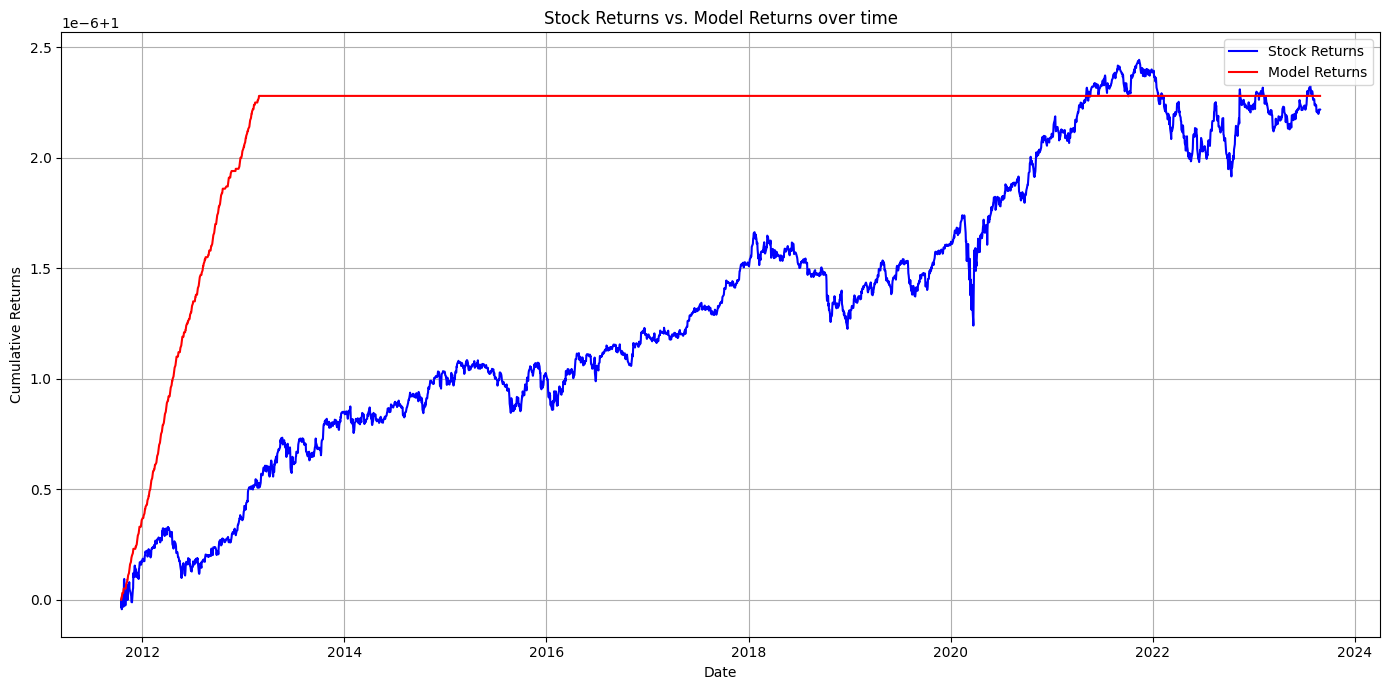

In [19]:

# Assuming you've already created the 'model_returns' column in your X_test dataframe as mentioned in the provided code
# Cumulative returns are a good way to visualize overall performance over time
X_test['cumulative_stock_returns'] = (1 + X_test['Return'] / 100000000).cumprod()
X_test['cumulative_model_returns'] = (1 + X_test['model_returns'] / 100000000).cumprod()

# Now, let's visualize it using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(X_test.index, X_test['cumulative_stock_returns'], label='Stock Returns', color='blue')
plt.plot(X_test.index, X_test['cumulative_model_returns'], label='Model Returns', color='red')
plt.title('Stock Returns vs. Model Returns over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [21]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
83/83 [==============================] - 5s 33ms/step - loss: 0.2688
Epoch 2/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2597
Epoch 3/100
83/83 [==============================] - 3s 35ms/step - loss: 0.2554
Epoch 4/100
83/83 [==============================] - 3s 35ms/step - loss: 0.2556
Epoch 5/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2539
Epoch 6/100
83/83 [==============================] - 3s 38ms/step - loss: 0.2540
Epoch 7/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2544
Epoch 8/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2522
Epoch 9/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2546
Epoch 10/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2527
Epoch 11/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2530
Epoch 12/100
83/83 [==============================] - 3s 36ms/step - loss: 0.2516
Epoch 13/100
83/83 [=====

In [22]:
blk.head()

Open    High      Low   Close  Adj Close   Volume
Date                                                           
1999-10-01  14.000  14.250  14.0000  14.125   8.955749  3162400
1999-10-04  14.125  14.125  14.0000  14.000   8.876496   533400
1999-10-05  14.000  14.125  14.0000  14.125   8.955749   270600
1999-10-06  14.125  14.875  14.1250  14.875   9.431278   205400
1999-10-07  14.875  14.875  14.0625  14.125   8.955749   214200

In [23]:
real_stock_price = blk.iloc[:, 1:2].values
real_stock_price


array([[ 14.25      ],
       [ 14.125     ],
       [ 14.125     ],
       ...,
       [688.58001709],
       [682.20001221],
       [683.53997803]])

In [24]:
test

Open        High         Low       Close   Adj Close  \
Date                                                                     
2011-01-03  191.520004  195.000000  189.529999  190.190002  136.966141   
2011-01-04  191.259995  191.500000  188.710007  190.039993  136.858093   
2011-01-05  190.029999  192.839996  189.250000  192.000000  138.269608   
2011-01-06  192.679993  192.789993  188.360001  189.929993  136.778915   
2011-01-07  191.520004  191.520004  185.460007  188.360001  135.648285   
...                ...         ...         ...         ...         ...   
2023-08-22  671.590027  674.760010  664.609985  665.840027  665.840027   
2023-08-23  668.400024  680.330017  667.119995  678.770020  678.770020   
2023-08-24  678.780029  688.580017  672.969971  673.159973  673.159973   
2023-08-25  676.000000  682.200012  671.260010  675.960022  675.960022   
2023-08-28  681.309998  683.539978  674.630005  679.000000  679.000000   

             Volume  Close_Shift    Return  target  
Date                                                
2011-01-03  1085200          NaN       NaN       0  
2011-01-04   794400   136.966141 -0.078886       1  
2011-01-05   925300   136.858093  1.031371       0  
2011-01-06   727300   138.269608 -1.078105       0  
2011-01-07   886200   136.778915 -0.826612       1  
...             ...          ...       ...     ...  
2023-08-22   332500   671.590027 -0.856177       1  
2023-08-23   386800   665.840027  1.941907       0  
2023-08-24   317900   678.770020 -0.826502       1  
2023-08-25   275200   673.159973  0.415956       1  
2023-08-28   430900   675.960022  0.449727       0  

[3184 rows x 9 columns]

In [25]:
training_set = train.iloc[:, 1:2].values

In [26]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [27]:
dataset_total = pd.concat((train['Open'], train['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(46, 62):  # Adjusted from (60, 76) to (46, 62)
    X_test.append(inputs[i-46:i, 0])  # Adjusted from i-60 to i-46
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 667ms/step


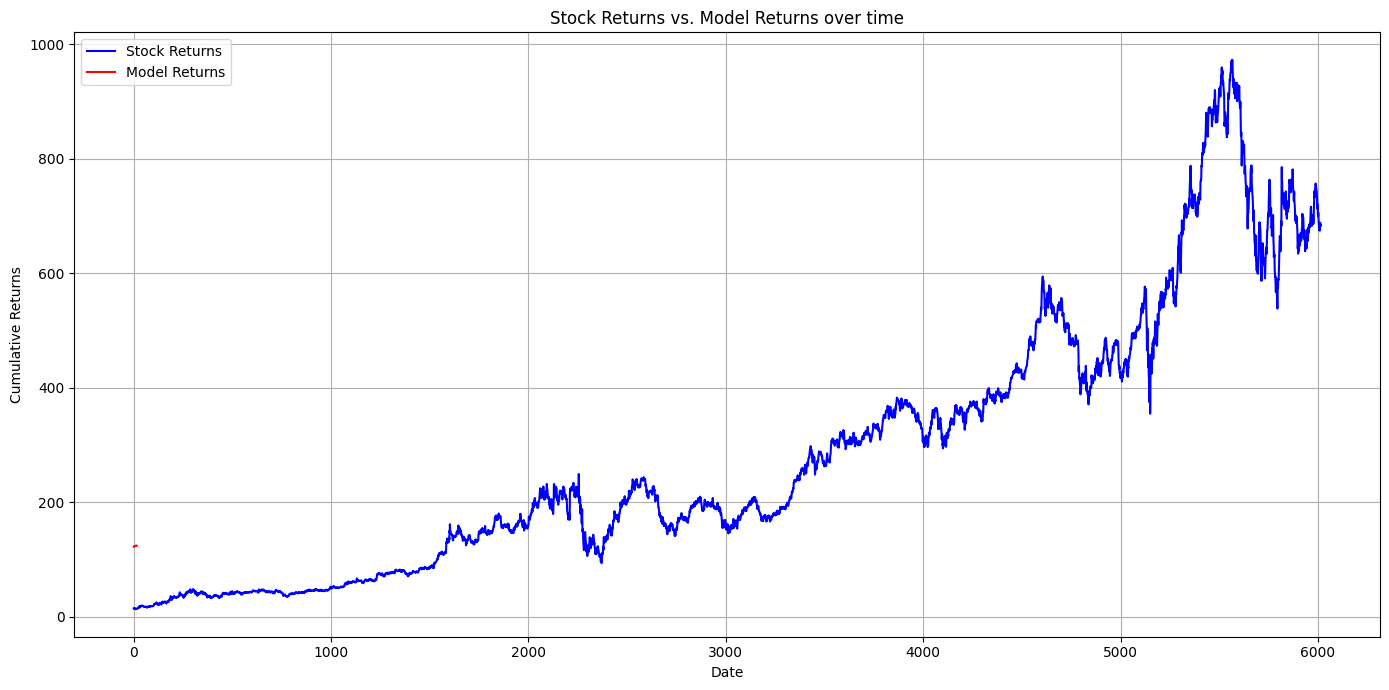

In [28]:
# Now, let's visualize it using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(real_stock_price, label='Stock Returns', color='blue')
plt.plot(predicted_stock_price, label='Model Returns', color='red')
plt.title('Stock Returns vs. Model Returns over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusion, none of these models are great fit for prediction of the actual stock returns for Black Rock.

In [1]:
# Importing libraries
import pandas as pd
import plotly.express as px 
import ydata_profiling as yp
import yfinance as yf
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
# Obtaining data 
df = yf.Ticker('BLK')
# Selecting historical prices period
blk = df.history(period='30y') # Last 30 years
# See dataframe
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876500    9.035009    8.876500    8.955754   
1999-10-04 00:00:00-04:00    8.955753    8.955753    8.876498    8.876498   
1999-10-05 00:00:00-04:00    8.876500    8.955754    8.876500    8.955754   
1999-10-06 00:00:00-04:00    8.955749    9.431275    8.955749    9.431275   
1999-10-07 00:00:00-04:00    9.431281    9.431281    8.916127    8.955754   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.380005  693.794983  704.335022   

                            Volume  Dividends  Stock Splits  
Date                                                         
1999-10-01 00:00:00-04:00  3162400        0.0           0.0  
1999-10-04 00:00:00-04:00   533400        0.0           0.0  
1999-10-05 00:00:00-04:00   270600        0.0           0.0  
1999-10-06 00:00:00-04:00   205400        0.0           0.0  
1999-10-07 00:00:00-04:00   214200        0.0           0.0  
...                            ...        ...           ...  
2023-08-25 00:00:00-04:00   275200        0.0           0.0  
2023-08-28 00:00:00-04:00   430900        0.0           0.0  
2023-08-29 00:00:00-04:00   502600        0.0           0.0  
2023-08-30 00:00:00-04:00   483900        0.0           0.0  
2023-08-31 00:00:00-04:00   229949        0.0           0.0  

[6018 rows x 7 columns]

In [3]:
# Using Pandas Profiling to generate a report on our dataframe
Profile_1 = yp.ProfileReport(blk)
Profile_1.to_file("Report1.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/haochenmiao/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Removing 'Dividends' and 'Stock Splits' columns
blk = blk.drop(['Dividends','Stock Splits'], axis = 1)
# See results
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876500    9.035009    8.876500    8.955754   
1999-10-04 00:00:00-04:00    8.955753    8.955753    8.876498    8.876498   
1999-10-05 00:00:00-04:00    8.876500    8.955754    8.876500    8.955754   
1999-10-06 00:00:00-04:00    8.955749    9.431275    8.955749    9.431275   
1999-10-07 00:00:00-04:00    9.431281    9.431281    8.916127    8.955754   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.380005  693.794983  704.335022   

                            Volume  
Date                                
1999-10-01 00:00:00-04:00  3162400  
1999-10-04 00:00:00-04:00   533400  
1999-10-05 00:00:00-04:00   270600  
1999-10-06 00:00:00-04:00   205400  
1999-10-07 00:00:00-04:00   214200  
...                            ...  
2023-08-25 00:00:00-04:00   275200  
2023-08-28 00:00:00-04:00   430900  
2023-08-29 00:00:00-04:00   502600  
2023-08-30 00:00:00-04:00   483900  
2023-08-31 00:00:00-04:00   229949  

[6018 rows x 5 columns]

In [5]:
# Adding two simple moving averages in order to increase the number of features to be analyzed by PyCaret Regression models
blk['SMA7'] = blk.Close.rolling(window=7).mean().round(2)
blk['SMA30'] = blk.Close.rolling(window=30).mean().round(2)
# See results
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876500    9.035009    8.876500    8.955754   
1999-10-04 00:00:00-04:00    8.955753    8.955753    8.876498    8.876498   
1999-10-05 00:00:00-04:00    8.876500    8.955754    8.876500    8.955754   
1999-10-06 00:00:00-04:00    8.955749    9.431275    8.955749    9.431275   
1999-10-07 00:00:00-04:00    9.431281    9.431281    8.916127    8.955754   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.380005  693.794983  704.335022   

                            Volume    SMA7   SMA30  
Date                                                
1999-10-01 00:00:00-04:00  3162400     NaN     NaN  
1999-10-04 00:00:00-04:00   533400     NaN     NaN  
1999-10-05 00:00:00-04:00   270600     NaN     NaN  
1999-10-06 00:00:00-04:00   205400     NaN     NaN  
1999-10-07 00:00:00-04:00   214200     NaN     NaN  
...                            ...     ...     ...  
2023-08-25 00:00:00-04:00   275200  672.80  709.34  
2023-08-28 00:00:00-04:00   430900  673.51  707.71  
2023-08-29 00:00:00-04:00   502600  676.48  706.11  
2023-08-30 00:00:00-04:00   483900  679.94  704.40  
2023-08-31 00:00:00-04:00   229949  685.44  702.85  

[6018 rows x 7 columns]

In [6]:
# Generating new report with pandas_profiling
Profile_2 = yp.ProfileReport(blk)
Profile_2.to_file("Report2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/haochenmiao/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Using plotly to plot a candlestick chart of the last 30 years
fig = go.Figure(data=[go.Candlestick(x = blk.index,
                                    open = blk.Open,
                                    high = blk.High,
                                    low = blk.Low,
                                    close = blk.Close),
                     go.Scatter(x=blk.index, y = blk.SMA7, line=dict(color='orange',width=1),name='SMA7'),
                     go.Scatter(x=blk.index, y = blk.SMA30, line=dict(color='green',width=1.5),name='SMA30')])
fig.update_layout(title = 'BlackRock stocks from Oct 10th, 1999 to Aug 30th, 2023')
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()

In [8]:
# Creating a new dataframe containing the last 2 years data to later test how well our predicting model will compare to the closing prices
blk_predict = blk.tail(506)
# See results
blk_predict

Open        High         Low       Close  \
Date                                                                        
2021-08-27 00:00:00-04:00  891.600224  907.109222  891.600224  906.928772   
2021-08-30 00:00:00-04:00  911.079071  911.629926  899.938835  900.413696   
2021-08-31 00:00:00-04:00  902.370142  905.314261  892.787408  895.864502   
2021-09-01 00:00:00-04:00  897.488464  899.853266  889.900185  896.367798   
2021-09-02 00:00:00-04:00  901.638663  906.843127  898.533049  902.873291   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.380005  693.794983  704.335022   

                           Volume    SMA7   SMA30  
Date                                               
2021-08-27 00:00:00-04:00  454600  883.02  851.77  
2021-08-30 00:00:00-04:00  284000  889.03  855.03  
2021-08-31 00:00:00-04:00  595000  892.57  857.07  
2021-09-01 00:00:00-04:00  324200  894.74  859.00  
2021-09-02 00:00:00-04:00  349400  897.65  861.65  
...                           ...     ...     ...  
2023-08-25 00:00:00-04:00  275200  672.80  709.34  
2023-08-28 00:00:00-04:00  430900  673.51  707.71  
2023-08-29 00:00:00-04:00  502600  676.48  706.11  
2023-08-30 00:00:00-04:00  483900  679.94  704.40  
2023-08-31 00:00:00-04:00  229949  685.44  702.85  

[506 rows x 7 columns]

In [9]:
# Removing last 2 years from the original dataframe
blk.drop(blk_predict.index,inplace = True)
# See results
blk

Open        High         Low       Close  \
Date                                                                        
1999-10-01 00:00:00-04:00    8.876500    9.035009    8.876500    8.955754   
1999-10-04 00:00:00-04:00    8.955753    8.955753    8.876498    8.876498   
1999-10-05 00:00:00-04:00    8.876500    8.955754    8.876500    8.955754   
1999-10-06 00:00:00-04:00    8.955749    9.431275    8.955749    9.431275   
1999-10-07 00:00:00-04:00    9.431281    9.431281    8.916127    8.955754   
...                               ...         ...         ...         ...   
2021-08-20 00:00:00-04:00  860.344830  876.214669  858.169926  871.057678   
2021-08-23 00:00:00-04:00  876.547029  886.974971  876.176623  881.210144   
2021-08-24 00:00:00-04:00  882.292817  886.737514  878.294462  882.473267   
2021-08-25 00:00:00-04:00  886.614119  898.305209  883.518012  892.283997   
2021-08-26 00:00:00-04:00  895.028628  895.209078  887.202918  888.826965   

                            Volume    SMA7   SMA30  
Date                                                
1999-10-01 00:00:00-04:00  3162400     NaN     NaN  
1999-10-04 00:00:00-04:00   533400     NaN     NaN  
1999-10-05 00:00:00-04:00   270600     NaN     NaN  
1999-10-06 00:00:00-04:00   205400     NaN     NaN  
1999-10-07 00:00:00-04:00   214200     NaN     NaN  
...                            ...     ...     ...  
2021-08-20 00:00:00-04:00   384700  867.34  844.55  
2021-08-23 00:00:00-04:00   351300  868.60  844.93  
2021-08-24 00:00:00-04:00   288500  870.27  845.59  
2021-08-25 00:00:00-04:00   329900  872.26  847.47  
2021-08-26 00:00:00-04:00   272300  875.82  849.24  

[5512 rows x 7 columns]

In [10]:
# Removing NaN
blk.dropna(inplace=True)
# See Results
blk

Open        High         Low       Close  \
Date                                                                        
1999-11-11 00:00:00-05:00   10.184192   10.303073   10.184192   10.223819   
1999-11-12 00:00:00-05:00   10.303074   11.729653   10.303074   11.412636   
1999-11-15 00:00:00-05:00   11.531517   11.531517   11.095618   11.214499   
1999-11-16 00:00:00-05:00   11.214496   11.214496   11.016360   11.055987   
1999-11-17 00:00:00-05:00   11.214496   11.571141   10.937106   11.095614   
...                               ...         ...         ...         ...   
2021-08-20 00:00:00-04:00  860.344830  876.214669  858.169926  871.057678   
2021-08-23 00:00:00-04:00  876.547029  886.974971  876.176623  881.210144   
2021-08-24 00:00:00-04:00  882.292817  886.737514  878.294462  882.473267   
2021-08-25 00:00:00-04:00  886.614119  898.305209  883.518012  892.283997   
2021-08-26 00:00:00-04:00  895.028628  895.209078  887.202918  888.826965   

                           Volume    SMA7   SMA30  
Date                                               
1999-11-11 00:00:00-05:00   20000   10.00    9.12  
1999-11-12 00:00:00-05:00  248500   10.29    9.20  
1999-11-15 00:00:00-05:00   99200   10.54    9.28  
1999-11-16 00:00:00-05:00   95300   10.69    9.35  
1999-11-17 00:00:00-05:00  107900   10.77    9.41  
...                           ...     ...     ...  
2021-08-20 00:00:00-04:00  384700  867.34  844.55  
2021-08-23 00:00:00-04:00  351300  868.60  844.93  
2021-08-24 00:00:00-04:00  288500  870.27  845.59  
2021-08-25 00:00:00-04:00  329900  872.26  847.47  
2021-08-26 00:00:00-04:00  272300  875.82  849.24  

[5483 rows x 7 columns]

In [11]:
# Importing regression lib from PyCaret
from pycaret.regression import *
setup(data = blk, target = 'Close',session_id=123)

In [12]:
ridge = create_model('ridge',fold = 10)

In [13]:
br = create_model('br',fold=10)

In [14]:
lar = create_model('lar',fold=10)

## Tuning Models

In [15]:
# Tuning ridge
ridge_params = {'alpha' : [0.02,0.024,0.025,0.025,0.026,0.03]}
tune_ridge = tune_model(ridge, n_iter=1000, optimize='RMSE',custom_grid = ridge_params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


In [16]:
# Tuning Bayesian Ridge
tune_br = tune_model(br,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


In [17]:
# Tuning Least Angle Regression 
tune_lar = tune_model(lar,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 22 candidates, totalling 220 fits


## Visualizing Data

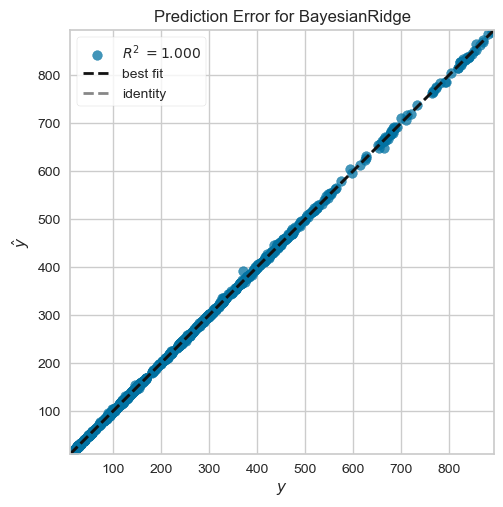

In [18]:
# Error plot
plot_model(tune_br, plot = 'error')

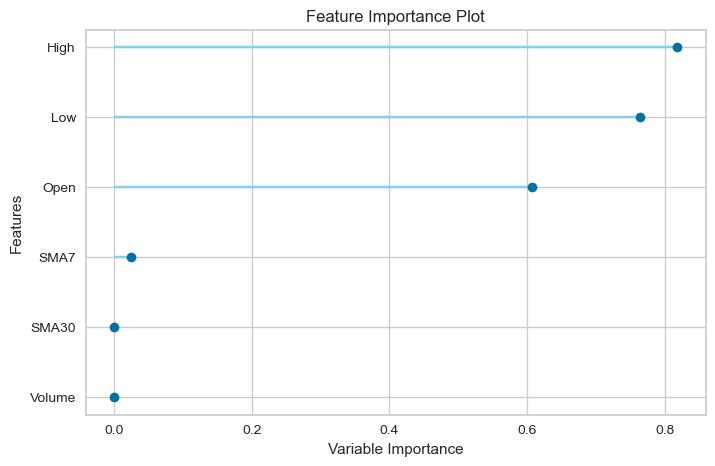

In [19]:
# Importance Feature Plot
plot_model(tune_br, plot = 'feature')

## Finalized Model

In [20]:
# Finalizing model
final_br_model = finalize_model(tune_br)

In [21]:
# Predicting last 2 years
prediction = predict_model(final_br_model,
                          data = blk_predict)
prediction

Open        High         Low  Volume  \
Date                                                                    
2021-08-27 00:00:00-04:00  891.600220  907.109192  891.600220  454600   
2021-08-30 00:00:00-04:00  911.079041  911.629944  899.938843  284000   
2021-08-31 00:00:00-04:00  902.370117  905.314270  892.787415  595000   
2021-09-01 00:00:00-04:00  897.488464  899.853271  889.900208  324200   
2021-09-02 00:00:00-04:00  901.638672  906.843140  898.533020  349400   
...                               ...         ...         ...     ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  275200   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  430900   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  502600   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  483900   
2023-08-31 00:00:00-04:00  697.869995  704.380005  693.794983  229949   

                                 SMA7       SMA30       Close  \
Date                                                            
2021-08-27 00:00:00-04:00  883.020020  851.770020  906.928772   
2021-08-30 00:00:00-04:00  889.030029  855.030029  900.413696   
2021-08-31 00:00:00-04:00  892.570007  857.070007  895.864502   
2021-09-01 00:00:00-04:00  894.739990  859.000000  896.367798   
2021-09-02 00:00:00-04:00  897.650024  861.650024  902.873291   
...                               ...         ...         ...   
2023-08-25 00:00:00-04:00  672.799988  709.340027  675.960022   
2023-08-28 00:00:00-04:00  673.510010  707.710022  679.000000   
2023-08-29 00:00:00-04:00  676.479980  706.109985  691.030029   
2023-08-30 00:00:00-04:00  679.940002  704.400024  695.809998   
2023-08-31 00:00:00-04:00  685.440002  702.849976  704.335022   

                           prediction_label  
Date                                         
2021-08-27 00:00:00-04:00        903.868927  
2021-08-30 00:00:00-04:00        902.581602  
2021-08-31 00:00:00-04:00        897.356804  
2021-09-01 00:00:00-04:00        893.770425  
2021-09-02 00:00:00-04:00        903.606877  
...                                     ...  
2023-08-25 00:00:00-04:00        676.942857  
2023-08-28 00:00:00-04:00        677.533689  
2023-08-29 00:00:00-04:00        686.908806  
2023-08-30 00:00:00-04:00        695.919305  
2023-08-31 00:00:00-04:00        699.430432  

[506 rows x 8 columns]

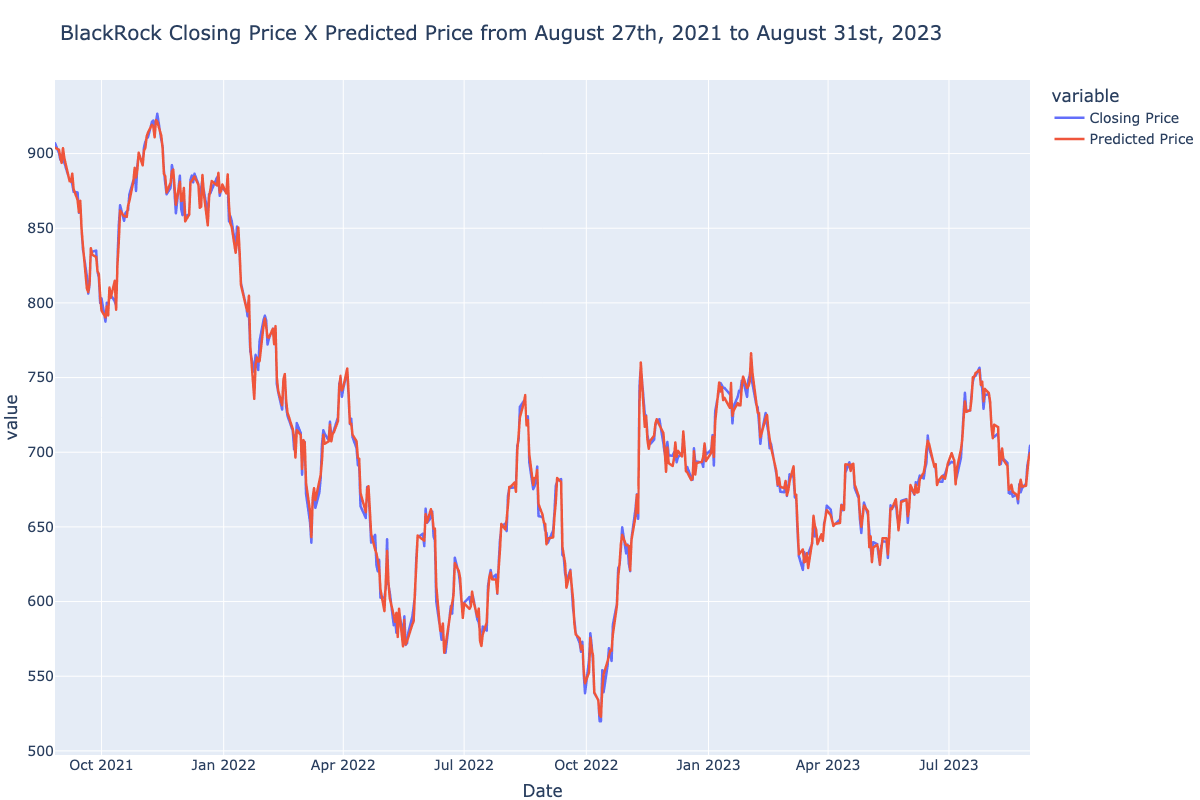

In [22]:
# Round the necessary columns first
prediction['Close'] = prediction['Close'].round(2)
prediction['prediction_label'] = prediction['prediction_label'].round(2)

fig = px.line(prediction, 
              x=prediction.index, 
              y=['Close', 'prediction_label'], 
              title='BLK close price x predicted price from August 27th, 2021 to August 31st, 2023')

newnames = {'Close':'Closing Price', 'prediction_label': 'Predicted Price'}  # Updated the mapping
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_traces(line=dict(width=2.5))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    title='BlackRock Closing Price X Predicted Price from August 27th, 2021 to August 31st, 2023',
    margin=dict(l=0, r=0, t=80, b=0),
    font=dict(size=14)
)
fig.show("png")


In [23]:
setup(data = blk, target = 'SMA30',session_id=123)

In [24]:
ridge = create_model('ridge',fold = 10)

In [25]:
br = create_model('br',fold=10)

In [26]:
lar = create_model('lar',fold=10)

In [27]:
# Tuning ridge
ridge_params = {'alpha' : [0.02,0.024,0.025,0.025,0.026,0.03]}
tune_ridge = tune_model(ridge, n_iter=1000, optimize='RMSE',custom_grid = ridge_params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [28]:
# Tuning Bayesian Ridge
tune_br = tune_model(br,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [29]:
# Tuning Least Angle Regression 
tune_lar = tune_model(lar,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 22 candidates, totalling 220 fits


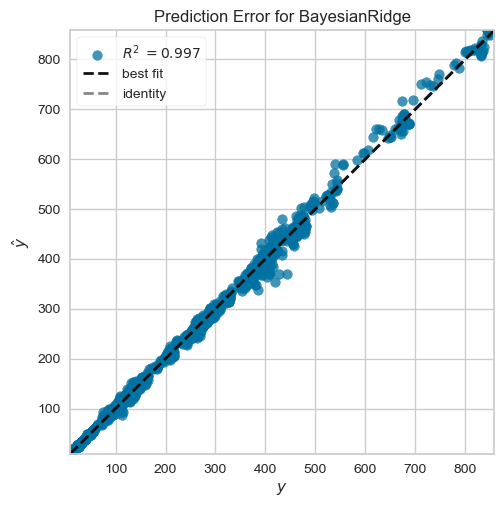

In [30]:
# Error plot
plot_model(tune_br, plot = 'error')

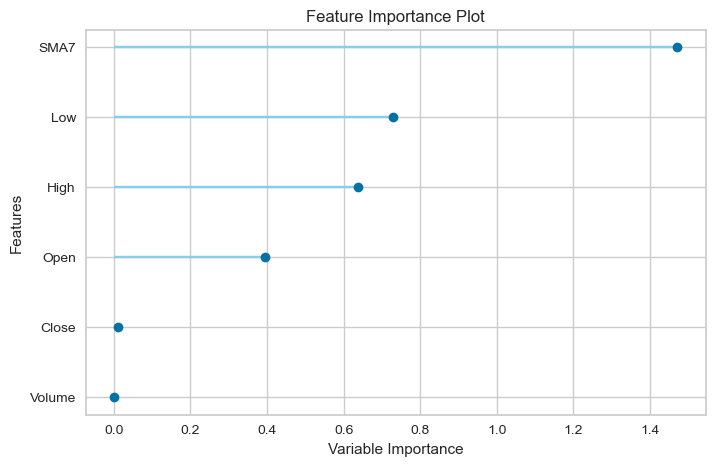

In [31]:
# Importance Feature Plot
plot_model(tune_br, plot = 'feature')

In [32]:
# Finalizing model
final_br_model = finalize_model(tune_br)

In [33]:
# Predicting last 2 years
prediction = predict_model(final_br_model,
                          data = blk_predict)
prediction

Open        High         Low       Close  \
Date                                                                        
2021-08-27 00:00:00-04:00  891.600220  907.109192  891.600220  906.928772   
2021-08-30 00:00:00-04:00  911.079041  911.629944  899.938843  900.413696   
2021-08-31 00:00:00-04:00  902.370117  905.314270  892.787415  895.864502   
2021-09-01 00:00:00-04:00  897.488464  899.853271  889.900208  896.367798   
2021-09-02 00:00:00-04:00  901.638672  906.843140  898.533020  902.873291   
...                               ...         ...         ...         ...   
2023-08-25 00:00:00-04:00  676.000000  682.200012  671.260010  675.960022   
2023-08-28 00:00:00-04:00  681.309998  683.539978  674.630005  679.000000   
2023-08-29 00:00:00-04:00  678.650024  691.460022  676.549988  691.030029   
2023-08-30 00:00:00-04:00  691.780029  699.500000  689.809998  695.809998   
2023-08-31 00:00:00-04:00  697.869995  704.380005  693.794983  704.335022   

                           Volume        SMA7       SMA30  prediction_label  
Date                                                                         
2021-08-27 00:00:00-04:00  454600  883.020020  851.770020        865.310763  
2021-08-30 00:00:00-04:00  284000  889.030029  855.030029        864.413193  
2021-08-31 00:00:00-04:00  595000  892.570007  857.070007        873.821486  
2021-09-01 00:00:00-04:00  324200  894.739990  859.000000        876.105286  
2021-09-02 00:00:00-04:00  349400  897.650024  861.650024        877.505004  
...                           ...         ...         ...               ...  
2023-08-25 00:00:00-04:00  275200  672.799988  709.340027        661.444468  
2023-08-28 00:00:00-04:00  430900  673.510010  707.710022        658.438254  
2023-08-29 00:00:00-04:00  502600  676.479980  706.109985        667.131091  
2023-08-30 00:00:00-04:00  483900  679.940002  704.400024        663.337935  
2023-08-31 00:00:00-04:00  229949  685.440002  702.849976        668.064451  

[506 rows x 8 columns]

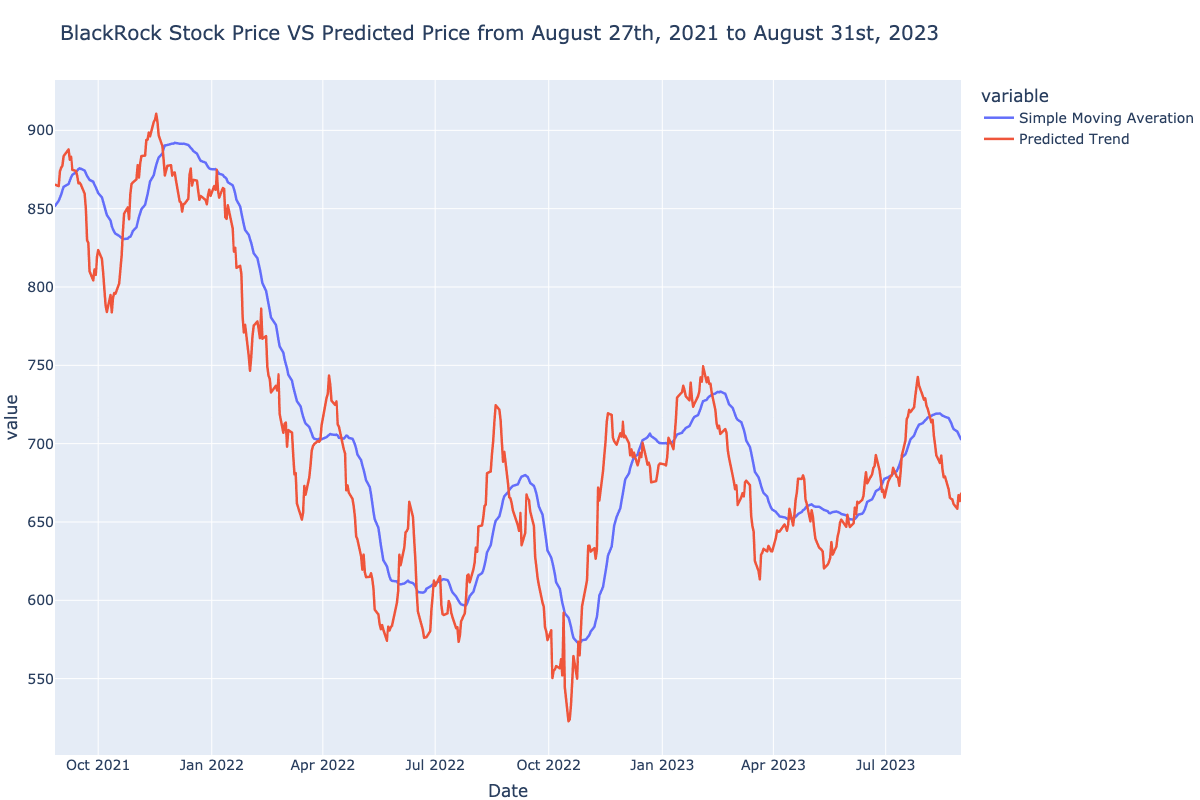

In [34]:
# Round the necessary columns first
prediction['SMA30'] = prediction['SMA30'].round(2)
prediction['prediction_label'] = prediction['prediction_label'].round(2)

fig = px.line(prediction, 
              x=prediction.index, 
              y=['SMA30', 'prediction_label'], 
              title='BLK stock price vs predicted price from August 27th, 2021 to August 31st, 2023')

newnames = {'SMA30':'Simple Moving Averation', 'prediction_label': 'Predicted Trend'}  # Updated the mapping
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_traces(line=dict(width=2.5))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    title='BlackRock Stock Price VS Predicted Price from August 27th, 2021 to August 31st, 2023',
    margin=dict(l=0, r=0, t=80, b=0),
    font=dict(size=14)
)
fig.show("png")

## Conclusion

Now this model is much better, I found that the Pycaret makes it the easy way to do all the modeling for predictions